In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_path = 'archive/lung_colon_image_set/lung_image_sets'
classes = ['lung_aca', 'lung_n', 'lung_scc']
image_size = (128, 128)

def load_images_and_labels(path, classes):
    images = []
    labels = []
    for class_index, class_name in enumerate(classes):
        class_folder = os.path.join(path, class_name)
        for filename in os.listdir(class_folder):
            img = cv2.imread(os.path.join(class_folder, filename), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, image_size)
                images.append(img)
                labels.append(class_index)
    return np.array(images), np.array(labels)

X, y = load_images_and_labels(dataset_path, classes)
X = X.reshape(-1, image_size[0], image_size[1], 1)  # Reshaping for CNN input
X = X / 255.0  # Normalizing pixel values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [5]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')  # Multi-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
282/282 [==============================] - ETA: 0s - loss: 0.9245 - accuracy: 0.5136

C:\Users\payal\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


282/282 [==============================] - 196s 683ms/step - loss: 0.9245 - accuracy: 0.5136 - val_loss: 0.4860 - val_accuracy: 0.7967
Epoch 2/10
282/282 [==============================] - 188s 667ms/step - loss: 0.5334 - accuracy: 0.7829 - val_loss: 0.7022 - val_accuracy: 0.7187
Epoch 3/10
282/282 [==============================] - 191s 677ms/step - loss: 0.4479 - accuracy: 0.8216 - val_loss: 0.3109 - val_accuracy: 0.8793
Epoch 4/10
282/282 [==============================] - 190s 672ms/step - loss: 0.4025 - accuracy: 0.8343 - val_loss: 0.4577 - val_accuracy: 0.7990
Epoch 5/10
282/282 [==============================] - 188s 667ms/step - loss: 0.3773 - accuracy: 0.8430 - val_loss: 0.2887 - val_accuracy: 0.8790
Epoch 6/10
282/282 [==============================] - 188s 666ms/step - loss: 0.3434 - accuracy: 0.8589 - val_loss: 0.2471 - val_accuracy: 0.9000
Epoch 7/10
282/282 [==============================] - 188s 668ms/step - loss: 0.3191 - accuracy: 0.8722 - val_loss: 0.2656 - val_accura

In [7]:
# Load the best model
model.load_weights('best_model.h5')

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test, y_pred_prob, multi_class='ovo', average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC-ROC: {auc_roc}')

94/94 [==============================] - 15s 149ms/step
Accuracy: 0.9296666666666666
Precision: 0.9310868028309057
Recall: 0.9296666666666666
AUC-ROC: 0.9903196235154297


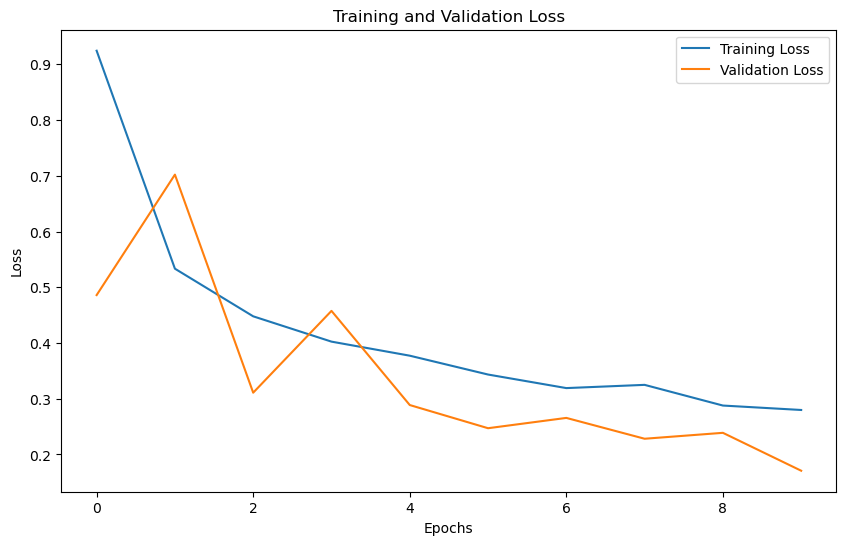

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

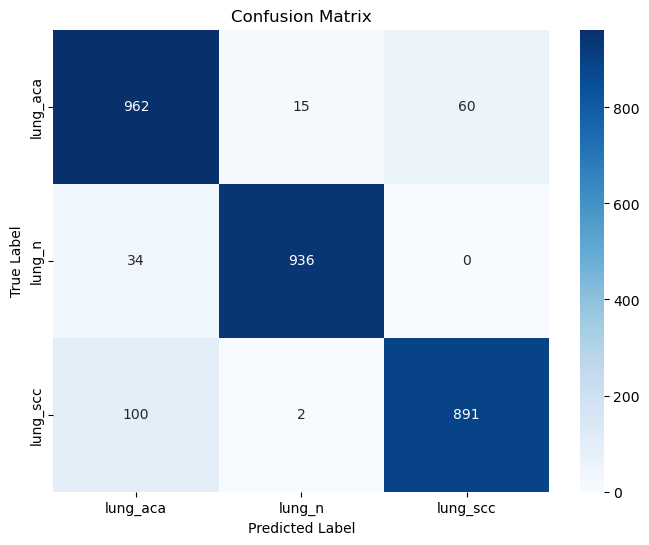

In [9]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

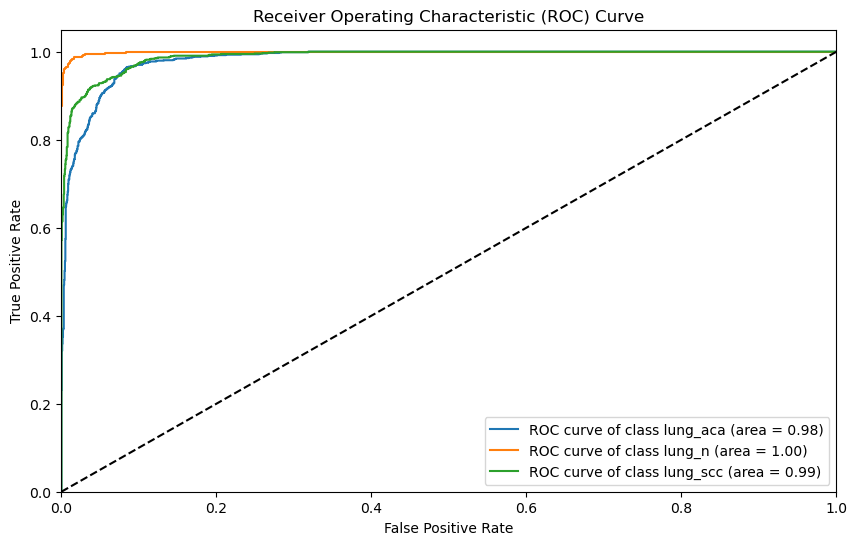

In [10]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()